**Exercise set 4**
==============


>The goal of this exercise is to perform **least-squares regression** and to see how we can estimate errors in the parameters we find.

**Exercise 4.1**

In this exercise we will use least-squares regression to investigate a physical phenomenon: the decay of beer froth with time. The file [erdinger.txt](Data/erdinger.txt) ('Data/erdinger.txt') contains [measured heights](https://doi.org/10.1088/0143-0807/23/1/304) for beer froth as a function of time, along with the errors in the measured heights.

**(a)**  Use least-squares regression to create a linear model that predicts the beer froth height as a function of time. Plot your linear model together with the raw data.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

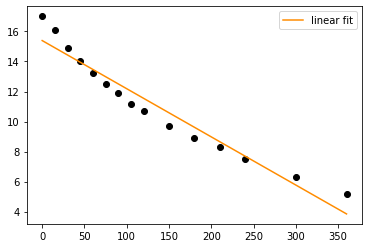

In [2]:
# Read the datafile
data = pd.read_csv("Data/erdinger.txt", delim_whitespace=True)
xdata = data['time'] # Select xdata
ydata = data['height'] # Select ydata

# Get the linear model
pfit = np.polyfit(x=xdata, y=ydata, deg=1) # Linear fit
yhat = np.polyval(p=pfit, x=xdata) # Get y_hat

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(xdata.values, ydata, c='black') # Plot raw data
ax.plot(xdata.values, yhat, label='linear fit', c='darkorange') # Plot fit
ax.legend(); # Add legend

**(b)**  Obtain the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), $R^2$, for your model.

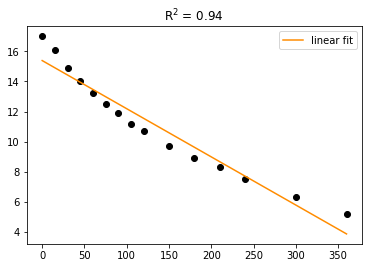

In [3]:
ss_res = np.sum((ydata-yhat)**2) # Get res squared
ss_tot = np.sum((ydata-ydata.mean())**2) # Get total variance
rsq = 1-(ss_res/ss_tot)
ax.set_title(rf'R$^2$ = {rsq:.2f}') # Use matplotlib to compile tex
fig # Show figure with new title

**(c)**  It is reasonable to assume that the change in the volume of froth is proportional
to the volume present at a given time. One can show that this leads
to exponential decay,

\begin{equation}
h(t) = h(0) \exp \left(-\frac{t}{\tau} \right),
\label{eq:hard}
\tag{1}\end{equation}

where $h(t)$ is the height of the froth as a function of time $t$, and $\tau$ is a parameter.
In the following, consider $h(0)$ as an unknown parameter to be determined. Show
how you can transform the equation above to a linear equation of the form,

\begin{equation}
y = a + b x,
\tag{2}\end{equation}

and give the relation(s) between the variables $h, h(0), t, \tau$ and 
$a, b, x, y$.

**Answer 4.1c:** 

Starting from:
\begin{equation}
h(t) = h(0) \exp \left(-\frac{t}{\tau} \right),
\end{equation}

we take the natural logarithm ("$\ln$") on both sides:

\begin{equation}
\begin{split}
\ln \left( \frac{h(t)}{h(0)} \right) &= \ln \left( \frac{h(t) \times 1\;\mathrm{cm}}{h(0) \times 1\;\mathrm{cm}} \right) \ln
\left( \exp \left(-\frac{t}{\tau} \right) \right) = -\frac{t}{\tau}, \\
\ln \left( \frac{h(t)}{1\;\mathrm{cm}} \right) &=
\ln \left( \frac{h(0)}{1\;\mathrm{cm}} \right)  -\frac{t}{\tau}. \\
\end{split}
\end{equation}

Comparing this with $y = a + bx$ gives:

\begin{equation}
\begin{split}
y &= \ln \left( \frac{h(t)}{1\;\mathrm{cm}} \right), \\
a &= \ln \left( \frac{h(0)}{1\;\mathrm{cm}} \right), \\
b &= -\frac{1}{\tau}, \\
x &= t.
\end{split}
\end{equation}

**Note:** The "1 cm" is included here to avoid taking the logarithm of a number with a unit.

**(d)**  Using the transformation found above, create a new linear model, and estimate $h(0)$ and $\tau$.
Further, calculate the coefficient of determination for this case, and compare the two
linear models you have found so far.

h0 = 16.21 cm, tau = 310.27 s


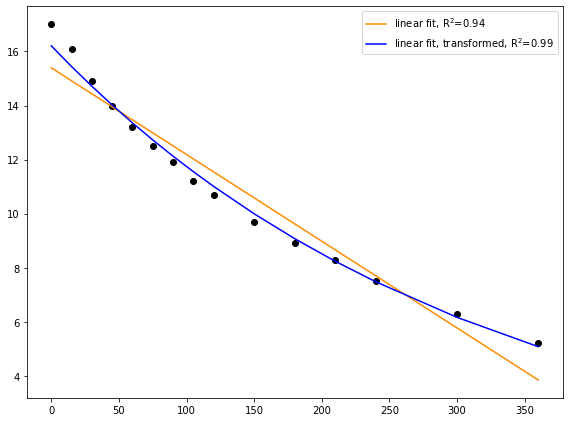

In [4]:
# Start with taking the ln of the data
ytrans = np.log(ydata)
# Repeat cell 2 and 3
pfittrans = np.polyfit(x=xdata, y=ytrans, deg=1) # Linear fit
yhattrans = np.polyval(p=pfittrans, x=xdata) # Get y_hat
rsq_trans = 1-(np.sum((ytrans-yhattrans)**2)/np.sum((ytrans-ytrans.mean())**2))

h0 = np.exp(pfittrans[-1])
tau = -1.0/pfittrans[-2]
print(f"h0 = {h0:.2f} cm, tau = {tau:.2f} s")

#Now we need to remake the plot and add rsq to the labels
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.4*1.5, 4.8*1.5))
ax.scatter(xdata, ydata, c='black') # Plot raw data
ax.plot(xdata.values, yhat, label=rf'linear fit, R$^2$={rsq:.2f}', c='darkorange') # Plot earlier fit
ax.plot(xdata.values, np.exp(yhattrans), 
        label=rf'linear fit, transformed, R$^2$={rsq_trans:.2f}', 
        c='blue') # plot current fit (transformed back to original data)
ax.legend();

**(e)**  From the analytical model Eq. (1), $h(0)$ is a known constant, equal to the height of
the froth at time zero. Thus, we can reformulate our model and fit it to just obtain
one parameter, $b$. Essentially, we are defining $y^\prime = y - a$ and using the model,

\begin{equation}
y^\prime = y - a = b x,
\tag{3}\end{equation}

that is, we have a linear model *without* the constant term.
Show that the least-squares solution for $b$ when fitting $y^\prime = bx$ is given by,

\begin{equation}
b = \frac{
\sum_{i=1}^n y_i^\prime x_i
}{\sum_{i=1}^n x_i^2
},
\label{eq:bexpr}
\tag{4}\end{equation}

where $n$ is the number of measurements and $x_i$ and $y_i^\prime$ are the
measured values.

**Answer 4.1e:** 
The residual is given by $r_i = y_i^\prime - b x_i$. The error is,

\begin{equation}
S = \sum_{i=1}^N r_i^2.
\end{equation}

Let us minimize the error. We have:

\begin{equation}
\frac{\partial S}{\partial b} = -2 \sum_{i=1}^N r_i x_i, \quad
\frac{\partial^2 S}{\partial b^2} = 2\sum_{i=1}^N x_i^2 \geq 0,
\end{equation}

Note that the second derivative is positive
(except for the trivial case when $x_i = 0$) and we are indeed going to
find a minimum.

Requiring that $\frac{\partial S}{\partial b} = 0$ gives,

\begin{equation}
-2 \sum_{i=1}^N r_i x_i = 0 \implies \sum_{i=1}^N (y_i^\prime x_i - b x_i^2) = 0 \implies 
b = \frac{\sum_{i=1}^N y_i^\prime x_i}{\sum_{i=1}^N x_i^2} .
\end{equation}

**(f)**  Do the fitting a final time, but use Eq. (4)
to obtain the parameter $b$.
Calculate the coefficient of determination and compare the three linear models you have found.

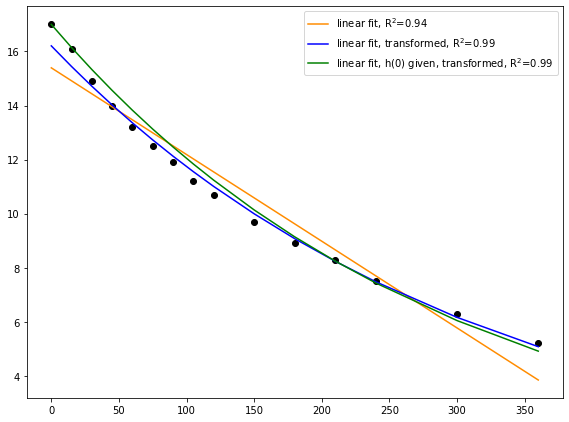

In [5]:
# First get yprime
yprime = ytrans-ytrans[0]

# Caluclate b
b = np.sum(yprime * xdata) / np.sum(xdata**2)

# Calculate yhat and rsq again
yhat3 = ytrans[0] + b*xdata.values
rsq3 = 1-(np.sum((ytrans-yhat3)**2)/np.sum((ytrans-ytrans.mean())**2))

#Add it to the original plot
ax.plot(xdata.values, np.exp(yhat3), 
        label=rf'linear fit, h(0) given, transformed, R$^2$={rsq3:.2f}', 
        c='green')
ax.legend() # Replot the legend
fig

**Exercise 4.2**

In this exercise, we will consider a linear model where we have one variable:

\begin{equation}
y = a + bx,
\end{equation}

and we have determined $a$ and $b$ using the least-squares equations. We further have
$n$ data points $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$ where the $x_i$'s do not have
any uncertainty, while the uncertainty in the $y_i$'s are all equal to $\sigma_y$.

> Our goal here is to find expressions for estimating
> the errors in the parameters $a$ and $b$,
> given the error in our measurements of $y$.

**Background information: Propagation of errors**

To be able to estimate the errors in $a$ and $b$, we will use [propagation of errors](https://en.wikipedia.org/wiki/Propagation_of_uncertainty).
For simplicity, consider a function, $f$, of two variables $u$ and $v$: $f = f(u, v)$.
By doing a Taylor expansion about the average values, $\bar{u}$ and $\bar{v}$, we can
show that the uncertainty (or "error") in the function $f$, $\sigma_f$, due to the uncertainties in $u$
and $v$ ($\sigma_u$ and $\sigma_v$, respectively) is given by:

\begin{equation}
\sigma_f^2 = \left(\frac{\partial f}{\partial u} \right)^2 \sigma_u^2 +
\left(\frac{\partial f}{\partial v} \right)^2 \sigma_v^2 +
2 \frac{\partial f}{\partial u} \frac{\partial f}{\partial v} \sigma_{uv} + \text{higher-order terms},
\end{equation}

where $\sigma_{uv}$ is the *covariance* between $u$ and $v$. Typically, the errors are "small"
and this motivates us to neglect the higher-order terms. Further, we will assume that the
variables $u$ and $v$ are *not* correlated: $\sigma_{uv} = 0$. We then arrive at the
(perhaps well-known) approximate propagation-of-errors-expression for the uncertainty in $f$:

\begin{equation}
\sigma_f^2 \approx \left(\frac{\partial f}{\partial u} \right)^2 \sigma_u^2 +
\left(\frac{\partial f}{\partial v} \right)^2 \sigma_v^2 .
\end{equation}

This can be generalized to $k$ variables, say $f=f(z_1, z_2, \ldots, z_k)$. The approximate
expression for the uncertainty in $f$, $\sigma_f$, due to the uncertainties
in the $z_i$'s, $\sigma_{z_{i}}$, is then:

\begin{equation}
\sigma_f^2 \approx \sum_{i=1}^{k} \left(\frac{\partial f}{\partial z_{i}} \right)^2 \sigma_{z_{i}}^2 .
\label{eq:errorp}
\tag{5}\end{equation}

We will use this expression to estimate the uncertainties in $a$ and $b$.

**Deriving expressions for the uncertainties in $a$ and $b$**

**(a)**  Show that the error in the $b$ parameter, $\sigma_b$,
is given by the following expression:

\begin{equation}
\sigma_b^2 = \frac{\sigma_y^2}{\sum_{i=1}^n \left(x_i - \bar{x}\right)^2},
\end{equation}

where $\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$ is the average of $x$.

***Hint:*** Use the least-squares expression for $b$:

\begin{equation}
b = \frac{
\sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y})
}{
\sum_{i=1}^n (x_i - \bar{x})^2
},
\end{equation}

together with the propagation-of-errors expression (Eq. (5)), and consider $b$ as a
function of the $y_i$'s: $b = f(y_1, y_2, \ldots, y_n)$. You might find it helpful to determine
$\frac{\partial b}{\partial y_j}$
as an intermediate step in your derivation. 

**Answer 4.2(a):**

We rewrite the least squares expression to save some typing:

\begin{equation*}
b = \frac{
\sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y})
}{
\sum_{i=1}^n (x_i - \bar{x})^2
} =
\frac{
\sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y})
}{
B
},
\end{equation*}

where we let $B=\sum_{i=1}^n (x_i - \bar{x})^2$.
Next, we are considering $b$ as a function of the $y_i$'s. To use the error
propagation approach, we now determine $\frac{\partial b}{\partial y_j}$.
First, it is helpful to determine the following:

\begin{equation*}
\begin{split}
\frac{\partial y_i}{\partial y_j} &= \delta_{ij}, \\
\frac{\partial \bar{y}}{\partial y_j} &= \frac{1}{n} \sum_{i=1}^{n} \frac{\partial y_i}{\partial y_j} 
= \frac{1}{n} \sum_{i=1}^{n} \delta_{ij} = \frac{1}{n},
\end{split}
\end{equation*}

where $\delta_{ij}$ is the Kronecker delta which is $1$ if $i=j$ and $0$ otherwise.
We then get,

\begin{equation*}
\begin{split}
\frac{\partial b}{\partial y_j}  &= \frac{1}{B} \sum_{i=1}^{n}
(x_i - \bar{x}) \left(
\frac{\partial y_i}{\partial y_j} -
\frac{\partial \bar{y}}{\partial y_j}
\right) = 
\frac{1}{B} \sum_{i=1}^{n} (x_i - \bar{x}) \left(\delta_{ij} - \frac{1}{n} \right) \\
&= \frac{1}{B} \left[
\sum_{i=1}^{n} x_i \delta_{ij}
- \sum_{i=1}^{n} \frac{x_i}{n}
- \sum_{i=1}^{n} \bar{x} \delta_{ij}
+ \sum_{i=1}^{n} \frac{\bar{x}}{n}
\right] \\
&= \frac{1}{B} \left[
x_j - \bar{x} - \bar{x} + \bar{x}
\right] \\
&= \frac{1}{B} (x_j - \bar{x}).
\end{split}
\end{equation*}

The error in $b$ is then:

\begin{equation*}
\begin{split}
\sigma_b^2 &= \sum_{i=1}^{n} \left( \frac{\partial b}{\partial y_i} \right)^2 \sigma_y^2 =
\frac{\sigma_y^2}{B^2} \sum_{i=1}^n (x_i - \bar{x})^2 = \frac{\sigma_y^2}{B^2} B = \frac{\sigma_y^2}{B} \\
&= \frac{\sigma_y^2}{\sum_{i=1}^n (x_i - \bar{x})^2},
\end{split}
\end{equation*}

which is the expression we were asked to derive.

**(b)**  Show that the error in the $a$ parameter, $\sigma_a$, is given by the following expression:

\begin{equation}
\sigma_a^2 = \frac{\sigma_y^2}{n} \times
\frac{
\sum_{i=1}^{n} x_i^2
}{
\sum_{i=1}^{n} (x_i - \bar{x})^2 
} .
\end{equation}

***Hint:*** Use the least-squares expression for $a$:

\begin{equation}
a = \bar{y} - b \bar{x},
\end{equation}

together with the propagation-of-errors expression (Eq. (5)), and consider $a$ as a
function of the $y_i$'s *and* $b$: $a = f(y_1, y_2, \ldots, y_n,b)$. You might find it
helpful to determine
$\frac{\partial a}{\partial y_j}$ and $\frac{\partial a}{\partial b}$ as intermediate steps
in your derivation.

**Answer 4.2(b):** 

For the error in $a$, we take the derivative of the least squares solution
$a = \bar{y} - b \bar{x}$:

\begin{equation*}
\begin{split}
\frac{\partial a}{\partial y_j} &= \frac{\partial \bar{y}}{\partial y_j} = \frac{1}{n}, \\
\frac{\partial a}{\partial b} &= - \bar{x}.
\end{split}
\end{equation*}

The error in $a$ is then:

\begin{equation*}
\begin{split}
\sigma_a^2 &= \sum_{i=1}^{n} \left( \frac{\partial a}{\partial y_i} \right)^2 \sigma_y^2 +
\left( \frac{\partial a}{\partial b} \right)^2 \sigma_b^2  \\
&= \frac{\sigma_y^2}{n^2} \left(\sum_{i=1}^n 1\right) + \bar{x}^2 \times \frac{\sigma_y^2}{\sum_{i=1}^n (x_i - \bar{x})^2} \\
&= \frac{\sigma_y^2}{n \sum_{i=1}^n (x_i - \bar{x})^2} \left[
\sum_{i=1}^n (x_i - \bar{x})^2 + n \bar{x}^2
\right] \\
&= \frac{\sigma_y^2}{n \sum_{i=1}^n (x_i - \bar{x})^2} \left[
\sum_{i=1}^n x_i^2 - 2 \bar{x} \sum_{i=1}^n x_i + \bar{x}^2 \sum_{i=1}^n 1 + n\bar{x}^2 
\right] \\
&= \frac{\sigma_y^2}{n \sum_{i=1}^n (x_i - \bar{x})^2} \left[
\sum_{i=1}^n x_i^2 - 2 n \bar{x}^2 + n \bar{x}^2 + n \bar{x}^2 
\right] \\
&= \frac{\sigma_y^2}{n} \times \frac{
\sum_{i=1}^n x_i^2
}{
 \sum_{i=1}^n (x_i - \bar{x})^2
},
\end{split}
\end{equation*}

which is the expression we were asked to derive.